# Seizing the Means of Tenserflow ☭
   
## Lab Seven: Wide and Deep Network Architectures
   
### Justin Ledford, Luke Wood, Traian Pop

In [1]:
%matplotlib inline
import numpy as np
import plotly
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import requests

import warnings
warnings.filterwarnings('ignore')

## Dataset Selection

For this project, we chose the Census-Income-MLD dataset from the UCI Machine Learning Repository due to nature of the set being exactly what we needed. The set has both categorical and integer data, a large number of attributes (40), and a very large number of instances (approximately 300,000). Not only that, but the data is also very applicable and highly wanted in our society.
   
The dataset's goal is to be able to predict whether a person, based on the values of their attributes, is under or over the 50k income bar. However, our goal for this report is not simply just accuracy. We are placing much heavier emphasis on catching false negatives in the over 50k limit section. The reason for this choise falls under the logic of marketing and advertising. Since the census is public knowledge, advertising companies tend to use it to be able to predict their target market and where they are most likely to have an affect. 
   
One target for these companies are individuals who make more than the average amount for they have more money to spend. If an advertiser is given a list that is missing a good deal of >50k individuals, they are also missing out on potential profit. This is something that our report will prioritize in order for a situation like that to be avoided.


## Preparation (40 points total)
   
### [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

In [2]:
import pandas as pd
import numpy as np
import requests


# Get column names
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/col_names.txt')

if r.status_code == 200:
    columns = r.text.replace(" ","_").replace("'","").split('\n')[:-1]
else:
    print('Error loading column names')

In [3]:
print(columns)

['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'weeks_worked_in_year', 'year', 'income']

As you can see, there is a large number of attributes, with categories ranging anywhere from age to benefits. In order to ease the work on our program and receive better results, we will be crossing some of these attributes together.

First we preprocess the data by removing the "weight" column which is irrelevant for training our classifier. We also remove any instances that are missing any feature values.

In [4]:
df_train = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz',
        compression='gzip', header=None, index_col=False)


df_test = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz',
        compression='gzip', header=None, index_col=False)


# Remove weight columns
df_train.drop(24, 1, inplace=True)
df_test.drop(24, 1, inplace=True)

df_train.columns = columns
df_test.columns = columns

# Remove rows with missing data and reset index
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_train.head()


,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


In [5]:
# Wage per hour to categorical
df_train["wage_per_hour"] = df_train["wage_per_hour"].map(lambda i: i==0)

Next, we encode all of our categorical attributes with one-hot encoding, and scale all of our continuous attributes.

In [6]:
# Process data:

# check income values consistent (only 2 values)

# replace categorical with one hot encoding
# scale continuous

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

labels = dict() 

r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/categorical.txt')
categorical_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]

for col in categorical_labels + ['income']:
    # strip extra space in strings
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].str.strip()
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].str.strip()
        
    # convert to ints for one hot encoder to work
    
    # keep labels for reference 
    labels[col] = list(set(df_train[col].unique()) | set(df_test[col].unique()))
    
    df_train[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)
    df_test[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)

categorical_labels

['class_of_worker',
 'industry_code',
 'occupation_code',
 'education',
 'enrolled_in_edu_inst_last_wk',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'tax_filer_status',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed',
 'fill_inc_questionnaire_for_veterans_admin',
 'veterans_benefits',
 'year',
 'wage_per_hour']

Above are our current categorical attributes.
   
Ideas for merging:
Country of birth categories too repetitive.
Industry and occupation code unreadable.

In [7]:
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/continuous.txt')
continuous_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]


for col in continuous_labels:
    df_train[col] = df_train[col].astype(np.float32)
    df_test[col] = df_test[col].astype(np.float32)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
continuous_labels

['age',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

Above are our current continuous attributes. 
   
Ideas for merging:
Turn most of these into categorical. Ranges like the Titanic dataset he showed us.

Next we see which attributes correlate most with our class.

In [8]:
def expected_data(observed):
    expected = np.zeros(observed.shape)

    total = observed.sum().sum()
    for j in [0, 1]:
        for i, col_total in enumerate(observed.sum()):
            row_total = observed.sum(axis=1)[j]
            expected[j][i] = row_total*col_total/total

    return pd.DataFrame(expected, index=observed.index,
                        columns=observed.columns)

In [9]:
df_freq = df_train.copy()
def attr_freqs(attr1, attr2):
    return pd.crosstab(df_freq[attr2], df_freq[attr1], rownames=[attr2], colnames=[attr1])

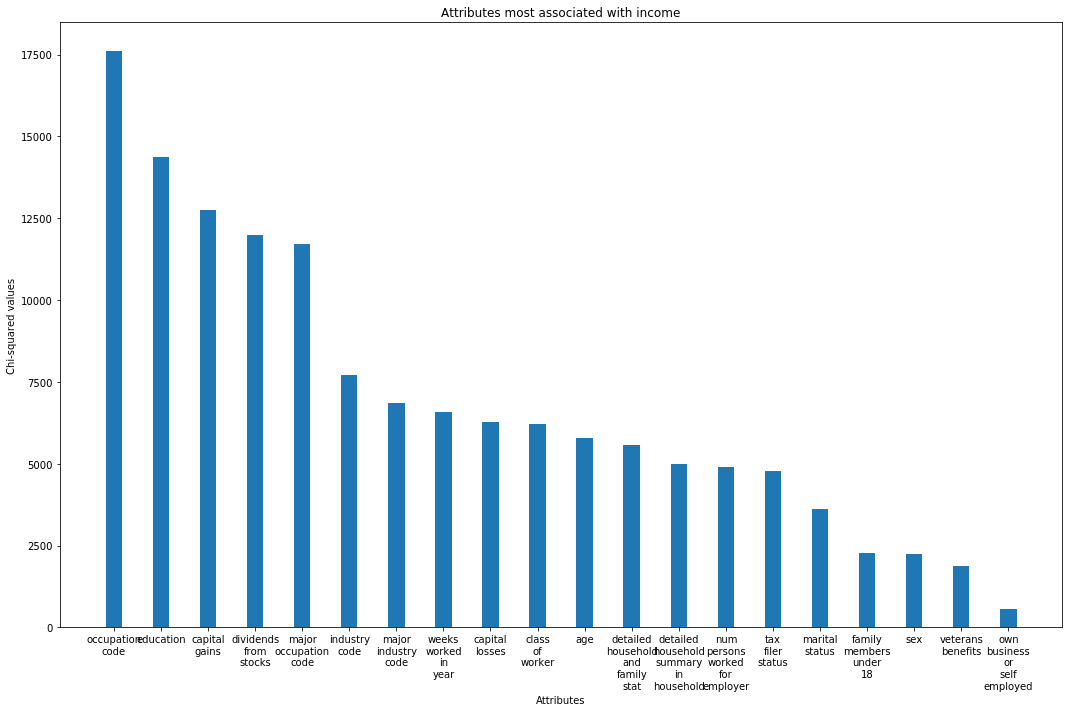

In [10]:
chisqrs = []

for colname in df_freq.columns:
    if colname != 'income':
        observed = attr_freqs(colname, 'income')
        expected = expected_data(observed)
        chisqr = (((observed-expected)**2)/expected).sum().sum()
        chisqrs.append((chisqr, colname))

chisqrs = sorted(chisqrs)[::-1]
chisqrs = chisqrs[:20]
values = [d[0] for d in chisqrs]
chi_labels = [d[1].replace("_", "\n") for d in chisqrs]

index = np.arange(len(chisqrs))
bar_width = .35
opacity=0.4

plt.figure(figsize=(15, 10))
plt.title("Attributes most associated with income")
plt.bar(index, values, bar_width, align='center')
plt.xticks(index, chi_labels)
plt.ylabel("Chi-squared values")
plt.xlabel("Attributes")
plt.autoscale()
plt.tight_layout()
plt.show()

Next we fix our high class imbalance.

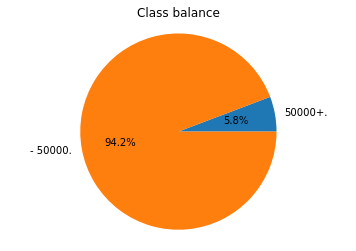

In [11]:
import matplotlib.pyplot as plt

sizes = np.bincount(df_train['income'].values)

plt.pie(sizes, labels=labels['income'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class balance')
plt.show()

In [12]:
# over sample class

df_ = df_train.copy().reset_index(drop=True)

total_size = df_.shape[0]
below50k_indices = df_[df_['income'] == 0].index
above50k_indices = df_[df_['income'] == 1].index

below50k_indices_sample = np.random.choice(below50k_indices, total_size // 2)
above50k_indices_sample = np.random.choice(above50k_indices, total_size // 2)

df_sampled = pd.concat([df_.iloc[below50k_indices_sample], df_.iloc[above50k_indices_sample]])
df_sampled = df_sampled.reset_index(drop=True)

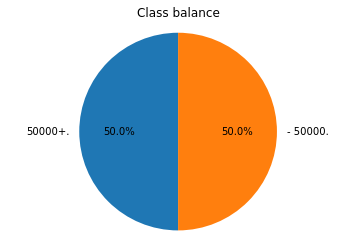

In [13]:
sizes = np.bincount(df_sampled['income'].values)

plt.pie(sizes, labels=labels['income'], startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Class balance')
plt.show()

### [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

As mentioned above, we are evaluating our model on how well we can classify the >50k class and avoid false negatives. We do this by scoring our model with a recall score.

### [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

The reason we choose Stratified Shuffle Split instead of the others is due to how large our dataset is and it is the recommended one by the source where we received our data from.
___

## Modeling (50 points total)
   
### [20 points] Create a combined wide and deep network to classify your data using tensorflow.

In [16]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

In [17]:
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input_cc(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.reshape(tf.constant(df[k].values), [-1]) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].astype(str).values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [18]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns():
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []    
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_labels:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=[str(x) for x in labels[col]])
        )
        
        dim = round(np.log2(len(labels[col]))) + 1
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    cross_columns = [('education','occupation_code'),('country_of_birth_father', 'country_of_birth_mother')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=[str(x) for x in labels[tup[0]]]),
                 layers.sparse_column_with_keys(tup[1], keys=[str(x) for x in labels[tup[1]]])],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in continuous_labels:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

### [20 points] Investigate generalization performance by altering the number of layers. Try at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab.

### Cross Column Analysis

In [19]:
%%time

from sklearn.neural_network import MLPClassifier
from numpy import interp

tf.logging.set_verbosity(tf.logging.ERROR)

df = df_sampled.sample(frac=0.01)
#df = df_train.sample(frac=0.01)
#df = df_sampled.copy()

X = df.drop('income', axis=1).values
y = df['income'].values

wide_columns, deep_columns = setup_wide_deep_columns()

for col in deep_columns:
    if col.dimension == 0.0:
        print(col)

        
mlp_roc_auc = []
dnn_roc_auc = []

mean_tpr_mlp = 0.0
mean_fpr_mlp = np.linspace(0, 1, 100)
mean_tpr_dnn = 0.0
mean_fpr_dnn = np.linspace(0, 1, 100)

n_splits = 5

sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5)

for train_index, test_index in sss.split(X, y):
    dnn = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50, 25, 5])
    
    mlp = MLPClassifier()
    
    X_train = df.drop('income', axis=1).iloc[train_index]
    y_train = df['income'].iloc[train_index]

    X_test = df.drop('income', axis=1).iloc[test_index]
    y_test = df['income'].iloc[test_index]
 
    input_wrapper = lambda:process_input_cc(df.iloc[train_index],'income',categorical_labels, continuous_labels)
    output_wrapper = lambda:process_input_cc(df.iloc[test_index],None,categorical_labels, continuous_labels)

    # when we provide the process function, they expect us to control the mini-batch
    dnn.fit(input_fn=input_wrapper, steps=500)
    mlp.fit(X_train, y_train)

    yhat_dnn = list(dnn.predict(input_fn=output_wrapper))
    yhat_mlp = mlp.predict(X_test)

    print('DNN')
    print(confusion_matrix(y_test,yhat_dnn),
          recall_score(y_test,yhat_dnn))
    
    print('MLP')
    print(confusion_matrix(y_test,yhat_mlp),
          recall_score(y_test,yhat_mlp))
    
    probs_dnn = list(dnn.predict_proba(input_fn=output_wrapper))
    probs_dnn = np.array(probs_dnn)[:,1]
    fpr_dnn, tpr_dnn, _ = roc_curve(y_test, probs_dnn)
    dnn_roc_auc.append((fpr_dnn, tpr_dnn, auc(fpr_dnn, tpr_dnn)))
    mean_tpr_dnn += interp(mean_fpr_dnn, fpr_dnn, tpr_dnn)
    mean_tpr_dnn[0] = 0.0   
    
    probs_mlp = mlp.predict_proba(X_test)
    probs_mlp = np.array(probs_mlp)[:,1]
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp)
    mlp_roc_auc.append((fpr_mlp, tpr_mlp, auc(fpr_mlp, tpr_mlp)))
    mean_tpr_mlp  += interp(mean_fpr_mlp, fpr_mlp, tpr_mlp)
    mean_tpr_mlp [0] = 0.0
    



DNN
[[186  48]
 [ 38 204]] 0.842975206612
MLP
[[183  51]
 [ 39 203]] 0.838842975207
DNN
[[208  26]
 [ 56 186]] 0.768595041322
MLP
[[178  56]
 [ 31 211]] 0.871900826446
DNN
[[214  20]
 [ 52 190]] 0.785123966942
MLP
[[198  36]
 [ 54 188]] 0.776859504132
DNN
[[212  22]
 [ 52 190]] 0.785123966942
MLP
[[207  27]
 [ 49 193]] 0.797520661157
DNN
[[209  25]
 [ 56 186]] 0.768595041322
MLP
[[184  50]
 [ 40 202]] 0.834710743802
CPU times: user 3min 39s, sys: 2.92 s, total: 3min 42s
Wall time: 3min 15s


In [20]:
mean_tpr_mlp /= n_splits
mean_tpr_mlp[-1] = 1.0
mean_auc_mlp = auc(mean_fpr_mlp, mean_tpr_mlp)

mean_tpr_dnn /= n_splits
mean_tpr_dnn[-1] = 1.0
mean_auc_dnn = auc(mean_fpr_dnn, mean_tpr_dnn)

### 10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.

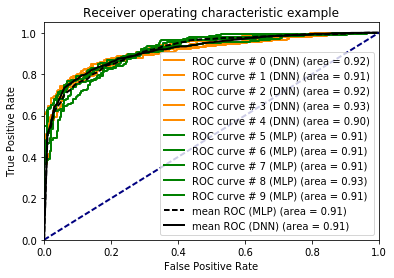

In [21]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
i = 0
for fpr, tpr, auc_ in dnn_roc_auc:
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve # %d (DNN) (area = %0.2f)' % (i, auc_))
        i += 1
for fpr, tpr, auc_ in mlp_roc_auc:
        plt.plot(fpr, tpr, color='green',
             lw=lw, label='ROC curve # %d (MLP) (area = %0.2f)' % (i, auc_))
        i += 1        
        
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'k--', label='mean ROC (MLP) (area = %0.2f)' % mean_auc_mlp, lw=2)
plt.plot(mean_fpr_dnn, mean_tpr_dnn, 'k-', label='mean ROC (DNN) (area = %0.2f)' % mean_auc_dnn, lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

## Exceptional Work (10 points total)
   
### One idea: Investigate which cross-product features are most important and hypothesize why.
___